<a href="https://colab.research.google.com/github/heitingv/Masters_project/blob/master/original_UNet_patches_WholeMass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install pydicom and barbar

In [0]:
!pip install pydicom
!pip install barbar

     |████████████████████████████████| 35.5MB 89kB/s 


Link to drive for data 

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


Import all libraries

In [0]:
import os
import matplotlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
from tqdm import tqdm_notebook as tqdm
from random import randint

import time
from barbar import Bar 
import progressbar
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from tqdm import trange
from time import sleep
from torch.utils.data.sampler import SubsetRandomSampler 
use_gpu = torch.cuda.is_available()

Class for data only with mass:
returns image/mask padded (for patch extraction) and image/mask resized to 250x250

In [0]:
class Dataset(BaseDataset):

    CLASSES = ['non tumor','tumor']

    def __init__(self, images_dir, masks_dir, classes=None):
        self.ids_f=[]
        self.ids_m_f=[]
        self.ids = os.listdir(images_dir)
        self.ids_m = os.listdir(masks_dir)
        for i in range(len(self.ids)):
          self.ids[i]=self.ids[i].rstrip(".dcm")
          for i in range(len(self.ids_m)):
            self.ids_m[i]=self.ids_m[i].rstrip(".png")

        for temp in self.ids_m:
          if temp in self.ids:
            self.ids_f.append(temp+'.dcm')
            self.ids_m_f.append(temp+'.png')

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids_f]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.ids_m_f]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __len__(self):
        return len(self.ids_f)
    
    def breast_left_or_right(self, image_array):
      position=None
      image=(image_array>0).float() #transform image into binary for easier analysis
      coordinates_breast_tissue=(image==1).nonzero() #look at coordinatex where there is '1'
      min_coordinates=torch.min(coordinates_breast_tissue,0)[0][1].item() #find the minimum column of where breast, if breast on the left then 0/1, if right then high number
      
      if  min_coordinates<=100:
        position='left'
      else:
        position='right'
      
      return(position)

    def image_padding(self, position, image_array, mask_array):

      if image_array.shape[0]==4084:
        if position=='left':
          image_tensor=torch.nn.functional.pad(image_array, (0,(3500-3328),0,(4250-4084)))
          mask_tensor=torch.nn.functional.pad(mask_array, (0,(3500-3328),0,(4250-4084)))
        else:
          image_tensor=torch.nn.functional.pad(image_array, ((3500-3328),0,0,(4250-4084)))
          mask_tensor=torch.nn.functional.pad(mask_array, ((3500-3328),0,0,(4250-4084)))
      
      else:
        if position=='left':
          image_tensor=torch.nn.functional.pad(image_array, (0,(2750-2560),0,(3500-3328)))
          mask_tensor=torch.nn.functional.pad(mask_array, (0,(2750-2560),0,(3500-3328)))
        else:
          image_tensor=torch.nn.functional.pad(image_array, ((2750-2560),0,0,(3500-3328)))
          mask_tensor=torch.nn.functional.pad(mask_array, ((2750-2560),0,0,(3500-3328)))
      
      return(image_tensor,mask_tensor)


    def __getitem__(self, i):
        
        # read data
        image = pydicom.dcmread(self.images_fps[i])
        image = image.pixel_array.astype('float')
        image_re = cv2.resize(image,(250,250))
        image = torch.from_numpy(image)
      
        mask = cv2.imread(self.masks_fps[i])
        mask_re = cv2.resize(mask,(250,250))
        mask_re = torch.from_numpy(mask_re)
        mask_re = mask_re.long()
        mask_re = abs((mask_re.sum(2)/3)-1)
        mask_re = (mask_re>0).float()
        mask = torch.from_numpy(mask)
        mask = mask.long()
        mask = abs((mask.sum(2)/3)-1)
        mask = (mask>0).float()

        position=self.breast_left_or_right(image)
        image_pad, mask_pad = self.image_padding(position,image,mask)
        
        return image_pad, mask_pad, image_re, mask_re

Class for data without mass: returns image/mask padded (for patch extraction) and image/mask resized to 250x250

The distinction between the two classes is be able to create a balanced dataset for training

In [0]:
class Dataset_with_NonMass(BaseDataset): #original data non padded or changed in size 

    CLASSES = ['non tumor','tumor']

    def __init__(self, images_dir, masks_dir, classes=None):
        self.ids_f=[]
        self.ids_m_f=[]
        self.ids = os.listdir(images_dir)
        self.ids_m = os.listdir(masks_dir)
        self.images_fps=[]
        self.masks_fps=[]
        for i in range(len(self.ids)):
          self.ids[i]=self.ids[i].rstrip(".dcm")
          for i in range(len(self.ids_m)):
            self.ids_m[i]=self.ids_m[i].rstrip(".png")

        for i in range(len(self.ids)):
          temp=self.ids[i][0:8]
          if temp in self.ids_m:
            self.ids_f.append(self.ids[i]+'.dcm')
            self.ids_m_f.append(temp+'.png')

        for i in range(len(self.ids_m_f)):
          mask_id=self.ids_m_f[i]
          image_id=self.ids_f[i]
          temp=os.path.join(masks_dir, mask_id)
          presence=self.test_mass(temp)

          if presence==False:
            self.images_fps.append(os.path.join(images_dir, image_id))
            self.masks_fps.append(os.path.join(masks_dir, mask_id))

          temp=None
          mask_id=None
          image_id=None

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

    def test_mass(self,name):
      presence=None

      mask = cv2.imread(name)
      mask = torch.from_numpy(mask)
      mask=mask.long()
      mask=abs((mask.sum(2)/3)-1)
      mask = (mask>0).float()

      if 1 in mask:
        presence=True
      else:
        presence=False

      return(presence)

    def __len__(self):
        return len(self.images_fps)

    def breast_left_or_right(self, image_array):
      position=None
      image=(image_array>0).float() #transform image into binary for easier analysis
      coordinates_breast_tissue=(image==1).nonzero() #look at coordinatex where there is '1'
      min_coordinates=torch.min(coordinates_breast_tissue,0)[0][1].item() #find the minimum column of where breast, if breast on the left then 0/1, if right then high number
      
      if  min_coordinates<=100:
        position='left'
      else:
        position='right'
      
      return(position)

    def image_padding(self, position, image_array, mask_array):

      if image_array.shape[0]==4084:
        if position=='left':
          image_tensor=torch.nn.functional.pad(image_array, (0,(3500-3328),0,(4250-4084)))
          mask_tensor=torch.nn.functional.pad(mask_array, (0,(3500-3328),0,(4250-4084)))
        else:
          image_tensor=torch.nn.functional.pad(image_array, ((3500-3328),0,0,(4250-4084)))
          mask_tensor=torch.nn.functional.pad(mask_array, ((3500-3328),0,0,(4250-4084)))
      
      else:
        if position=='left':
          image_tensor=torch.nn.functional.pad(image_array, (0,(2750-2560),0,(3500-3328)))
          mask_tensor=torch.nn.functional.pad(mask_array, (0,(2750-2560),0,(3500-3328)))
        else:
          image_tensor=torch.nn.functional.pad(image_array, ((2750-2560),0,0,(3500-3328)))
          mask_tensor=torch.nn.functional.pad(mask_array, ((2750-2560),0,0,(3500-3328)))
      
      return(image_tensor,mask_tensor)

    def __getitem__(self, i):
        
        # read data
        image = pydicom.dcmread(self.images_fps[i])
        image = image.pixel_array.astype('float')
        image_re = cv2.resize(image,(250,250))
        image = torch.from_numpy(image)
      
        mask = cv2.imread(self.masks_fps[i])
        mask_re = cv2.resize(mask,(250,250))
        mask_re = torch.from_numpy(mask_re)
        mask_re = mask_re.long()
        mask_re = abs((mask_re.sum(2)/3)-1)
        mask_re = (mask_re>0).float()
        mask = torch.from_numpy(mask)
        mask = mask.long()
        mask = abs((mask.sum(2)/3)-1)
        mask = (mask>0).float()

        position=self.breast_left_or_right(image)
        image_pad, mask_pad = self.image_padding(position,image,mask)

        return image_pad, mask_pad, image_re, mask_re

Class for whole mass patch extraction

In [0]:
class Patch_Extraction_Just_Tumour:

  CLASSES = ['non tumor','tumor']

  def __init__(self, image_tensor, mask_tensor, image_number, classes=None):
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.image_tensor=image_tensor
        self.mask_tensor=mask_tensor
        self.image_number=image_number

  def mass_or_not(self): #function to find if tumour present or not in mask
        if 1 in self.mask_tensor:
          return(True)
        else: 
          return(False)

  def four_corners_of_tumour(self): #returns coordinates of four corner of tumour 
        coordinates_tumour=(self.mask_tensor== 1).nonzero() 
    
        h_min=torch.min(coordinates_tumour,0)[0][0].item() #gets the minimum height coordinates of tumour
        h_max=torch.max(coordinates_tumour,0)[0][0].item() #gets the maximum height coordinates of tumour

        w_min=torch.min(coordinates_tumour,0)[0][1].item() #gets the minimum width coordinates of tumour
        w_max=torch.max(coordinates_tumour,0)[0][1].item() #gets the maximum height coordinates of tumour
        
        return(h_min, h_max, w_min, w_max)

  def get_patches_with_tumour(self): #returns patch of whole tumour 
        if self.mass_or_not()==True: #if there is a tumour
          (h_min, h_max, w_min, w_max)=self.four_corners_of_tumour()
          
          x_h=h_max-h_min #height of full tumour patch 
          x_w=w_max-w_min #width of full tumour patch
          image_patch=torch.zeros([x_h,x_w], dtype=torch.float)
          mask_patch=torch.zeros([x_h,x_w], dtype=torch.float)
            
          for j in range(x_h-1): 
            for i in range (x_w-1):
              mask_patch[j][i]=self.mask_tensor[h_min+j][w_min+i] #into mask_patch array put all pixel of tumour patch
              image_patch[j][i]=self.image_tensor[h_min+j][w_min+i] #into image_patch array put all the same pixel of image as mask_patch

        else: #if no tumour then just return a 200x200 array of zeros 
          h_min=round(((mask.squeeze().size()[0])/2)-100)
          h_max=h_min+200
          w_min=round(((mask.squeeze().size()[1])/2)-100)
          w_max=w_min+200

          x_h=200
          x_w=200
          
          image_patch=torch.zeros([x_h,x_w], dtype=torch.float)
          mask_patch=torch.zeros([x_h,x_w], dtype=torch.float)

          for j in range(x_h-1):
            for i in range (x_w-1):
              mask_patch[j][i]=self.mask_tensor[h_min+j][w_min+i]
              image_patch[j][i]=self.image_tensor[h_min+j][w_min+i]

        return (image_patch,mask_patch) #return mask and image full tumour patch

Load train, validation and test dataset from drive that was previously saved so that all trainings/testings are done on exactly the same images

In [0]:
test_loader=(torch.load('/gdrive/My Drive/test_loader.pth'))
train_loader=(torch.load('/gdrive/My Drive/train_loader.pth'))
val_loader=(torch.load('/gdrive/My Drive/val_loader.pth'))

UNet https://github.com/milesial/Pytorch-UNet

In [0]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
      
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Function to calculate IoU, Dice coeff etc

In [0]:
def metrics(predicted,truth,word):
  ####### metrics for tumour
  TP=0
  FN=0
  FP=0
  TN=0
  for i in range(truth.squeeze().size()[0]):
    for j in range(truth.squeeze().size()[1]):
      if truth[i,j]==1 and predicted[i,j]==1:
        TP+=1
      elif truth[i,j]==1 and predicted[i,j]==0:
        FN+=1
      elif truth[i,j]==0 and predicted[i,j]==1:
        FP+=1
      else:
        TN+=1
  
  if TP==0 and FP==0 and FN==0:
    iou_tumour=0
    dice_tumour=0
  else:
    iou_tumour = TP/(TP+FP+FN)
    dice_tumour = (2*TP)/(TP+FP+TP+FN)

  if TN==0 and FP==0:
    spec_tumour=0
  else:
    spec_tumour = TN/(TN+FP) #specificity #true negative rate
 
  if TP==0 and FN==0:
    sens_tumour=0
  else:
    sens_tumour = TP/(TP+FN) #sensitivity #true positive rate

  acc_tumour = (TP+TN)/(TP+TN+FP+FN) #accuracy

  ####### metrics for background
  truth_b=abs(truth-1)
  predicted_b=abs(predicted-1)
  TP_b=0
  FN_b=0
  FP_b=0
  TN_b=0
  for i in range(truth_b.squeeze().size()[0]):
    for j in range(truth_b.squeeze().size()[1]):
      if truth_b[i,j]==1 and predicted_b[i,j]==1:
        TP_b+=1
      elif truth_b[i,j]==1 and predicted_b[i,j]==0:
        FN_b+=1
      elif truth_b[i,j]==0 and predicted_b[i,j]==1:
        FP_b+=1
      else:
        TN_b+=1
  
  if TP_b==0 and FP_b==0 and FN_b==0:
    iou_background=0
    dice_background=0
  else:
    iou_background = TP_b/(TP_b+FP_b+FN_b)
    dice_background = (2*TP_b)/(TP_b+FP_b+TP_b+FN_b)

  if TN_b==0 and FP_b==0:
    spec_background=0
  else:
   spec_background = TN_b/(TN_b+FP_b) #specificity #true negative rate
 
  if TP_b==0 and FN_b==0:
    sens_background=0
  else:
    sens_background = TP_b/(TP_b+FN_b) #sensitivity #true positive rate

  acc_background = (TP_b+TN_b)/(TP_b+TN_b+FP_b+FN_b) #accuracy

  ####### metrics for mean of tumour & background
  object_nb=0
  if 1 not in truth:
    object_nb=1
  else:
    object_nb=2
  
  mean_iou=(iou_tumour+iou_background)/object_nb
  mean_dice=(dice_tumour+dice_background)/object_nb
  mean_spec=(spec_tumour+spec_background)/object_nb
  mean_sens=(sens_tumour+sens_background)/object_nb
  mean_acc=(acc_tumour+acc_background)/2
  
  if word=='iou':
    return(iou_tumour,iou_background,mean_iou)
  elif word=='AllTumour':
    return(iou_tumour,dice_tumour,spec_tumour,sens_tumour,acc_tumour)
  elif word=='AllBackground':
    return(iou_background,dice_background,spec_background,sens_background,acc_background)
  elif word=='AllMean':
    return(mean_iou,mean_dice,mean_spec,mean_sens,mean_acc)


Model

In [0]:
model = UNet(n_classes=2, n_channels=1)

Optimizer & criterion

In [0]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [0]:
path='/networks/original_UNet_patches_WholeMass/'
name='original_UNet_patches_WholeMass'

Training

100% (130 of 130) |######################| Elapsed Time: 0:16:22 Time:  0:16:22
100% (28 of 28) |########################| Elapsed Time: 0:03:26 Time:  0:03:26


Epoch 1 :iou train: 0.687 ; iou val: 0.711 ; tumour iou val: 0.707 



100% (130 of 130) |######################| Elapsed Time: 0:13:57 Time:  0:13:57
100% (28 of 28) |########################| Elapsed Time: 0:02:58 Time:  0:02:58


Epoch 2 :iou train: 0.760 ; iou val: 0.734 ; tumour iou val: 0.692 



100% (130 of 130) |######################| Elapsed Time: 0:13:51 Time:  0:13:51
100% (28 of 28) |########################| Elapsed Time: 0:02:58 Time:  0:02:58


Epoch 3 :iou train: 0.814 ; iou val: 0.744 ; tumour iou val: 0.693 



100% (130 of 130) |######################| Elapsed Time: 0:13:48 Time:  0:13:48
100% (28 of 28) |########################| Elapsed Time: 0:02:58 Time:  0:02:58


Epoch 4 :iou train: 0.843 ; iou val: 0.787 ; tumour iou val: 0.762 



100% (130 of 130) |######################| Elapsed Time: 0:14:01 Time:  0:14:01
100% (28 of 28) |########################| Elapsed Time: 0:03:02 Time:  0:03:02


Epoch 5 :iou train: 0.863 ; iou val: 0.735 ; tumour iou val: 0.673 



100% (130 of 130) |######################| Elapsed Time: 0:14:16 Time:  0:14:16
100% (28 of 28) |########################| Elapsed Time: 0:03:06 Time:  0:03:06


Epoch 6 :iou train: 0.846 ; iou val: 0.777 ; tumour iou val: 0.740 



100% (130 of 130) |######################| Elapsed Time: 0:14:30 Time:  0:14:30
100% (28 of 28) |########################| Elapsed Time: 0:03:06 Time:  0:03:06


Epoch 7 :iou train: 0.870 ; iou val: 0.757 ; tumour iou val: 0.697 



100% (130 of 130) |######################| Elapsed Time: 0:14:17 Time:  0:14:17
100% (28 of 28) |########################| Elapsed Time: 0:02:59 Time:  0:02:59


Epoch 8 :iou train: 0.877 ; iou val: 0.814 ; tumour iou val: 0.801 



100% (130 of 130) |######################| Elapsed Time: 0:14:08 Time:  0:14:08
100% (28 of 28) |########################| Elapsed Time: 0:03:02 Time:  0:03:02


Epoch 9 :iou train: 0.882 ; iou val: 0.797 ; tumour iou val: 0.801 



100% (130 of 130) |######################| Elapsed Time: 0:14:23 Time:  0:14:23
100% (28 of 28) |########################| Elapsed Time: 0:03:05 Time:  0:03:05


Epoch 10 :iou train: 0.889 ; iou val: 0.802 ; tumour iou val: 0.786 



100% (130 of 130) |######################| Elapsed Time: 0:14:23 Time:  0:14:23
100% (28 of 28) |########################| Elapsed Time: 0:03:04 Time:  0:03:04


Epoch 11 :iou train: 0.897 ; iou val: 0.801 ; tumour iou val: 0.777 



100% (130 of 130) |######################| Elapsed Time: 0:14:19 Time:  0:14:19
100% (28 of 28) |########################| Elapsed Time: 0:03:00 Time:  0:03:00


Epoch 12 :iou train: 0.902 ; iou val: 0.812 ; tumour iou val: 0.798 



100% (130 of 130) |######################| Elapsed Time: 0:14:16 Time:  0:14:16
100% (28 of 28) |########################| Elapsed Time: 0:03:04 Time:  0:03:04


Epoch 13 :iou train: 0.903 ; iou val: 0.799 ; tumour iou val: 0.770 



100% (130 of 130) |######################| Elapsed Time: 0:14:02 Time:  0:14:02
100% (28 of 28) |########################| Elapsed Time: 0:02:58 Time:  0:02:58


Epoch 14 :iou train: 0.912 ; iou val: 0.816 ; tumour iou val: 0.796 



100% (130 of 130) |######################| Elapsed Time: 0:14:05 Time:  0:14:05
100% (28 of 28) |########################| Elapsed Time: 0:03:02 Time:  0:03:02


Epoch 15 :iou train: 0.914 ; iou val: 0.803 ; tumour iou val: 0.780 



100% (130 of 130) |######################| Elapsed Time: 0:13:52 Time:  0:13:52
100% (28 of 28) |########################| Elapsed Time: 0:02:59 Time:  0:02:59


Epoch 16 :iou train: 0.920 ; iou val: 0.808 ; tumour iou val: 0.790 



100% (130 of 130) |######################| Elapsed Time: 0:14:10 Time:  0:14:10
100% (28 of 28) |########################| Elapsed Time: 0:03:03 Time:  0:03:03


Epoch 17 :iou train: 0.909 ; iou val: 0.805 ; tumour iou val: 0.799 



100% (130 of 130) |######################| Elapsed Time: 0:14:24 Time:  0:14:24
100% (28 of 28) |########################| Elapsed Time: 0:03:04 Time:  0:03:04


Epoch 18 :iou train: 0.916 ; iou val: 0.807 ; tumour iou val: 0.789 



100% (130 of 130) |######################| Elapsed Time: 0:14:23 Time:  0:14:23
100% (28 of 28) |########################| Elapsed Time: 0:03:06 Time:  0:03:06


Epoch 19 :iou train: 0.927 ; iou val: 0.803 ; tumour iou val: 0.782 



100% (130 of 130) |######################| Elapsed Time: 0:14:25 Time:  0:14:25
100% (28 of 28) |########################| Elapsed Time: 0:03:04 Time:  0:03:04


Epoch 20 :iou train: 0.932 ; iou val: 0.790 ; tumour iou val: 0.761 

Finished Training


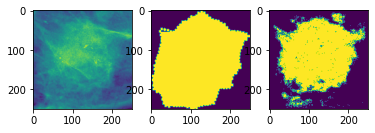

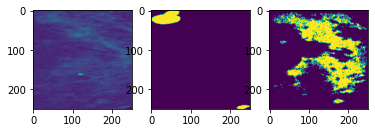

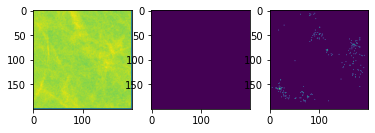

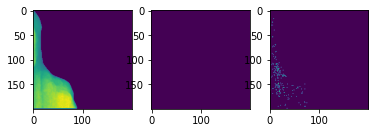

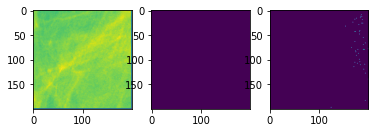

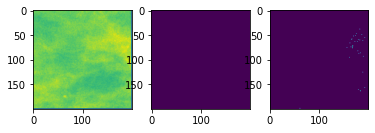

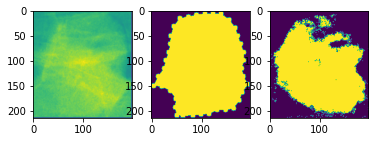

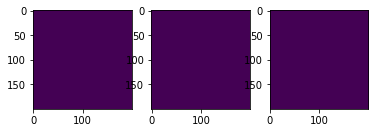

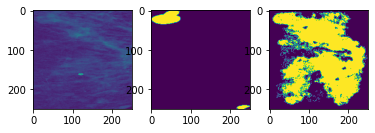

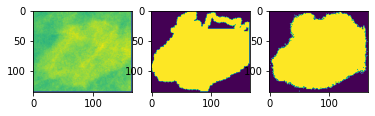

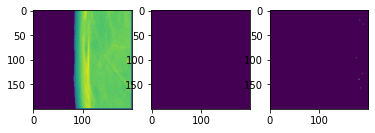

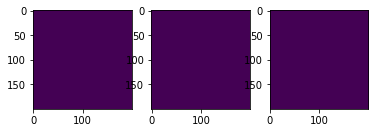

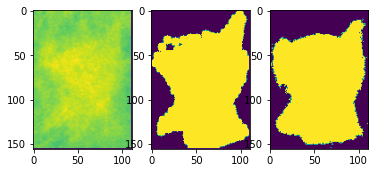

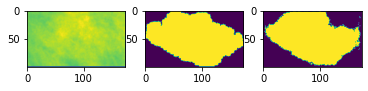

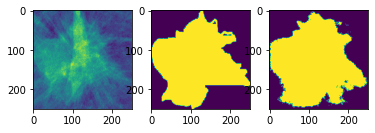

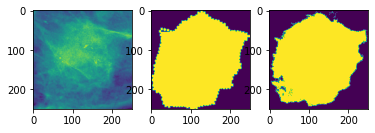

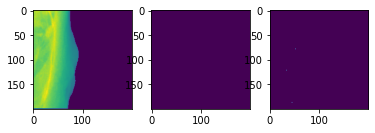

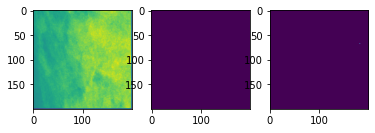

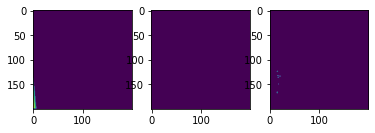

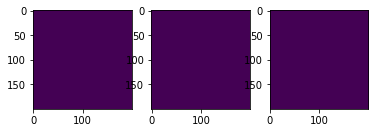

In [0]:
epochs=20
running_loss = 0.0
best=0.0
best_tumour=0.0
train_iou = 0.0
val_iou = 0.0
val_tumour_iou=[]
counter=0
iou_list=[]
val_iou_list=[]
nb_patches_analyzed=0
nb_patches_analyzed_v=0

file = open('/gdrive/My Drive'+path+'training.txt','w')
file.write('Training: 20 epochs on original UNet on whole mass patches\n')

time.sleep(5)
for epoch in range(epochs):  

    ###################### Training
    time.sleep(5)
    Bar = progressbar.ProgressBar(max_value=len(train_loader))
    for i, data in enumerate(Bar(train_loader), 0):
        image, mask, image_re, mask_re = data

        extract=Patch_Extraction_Just_Tumour(image.squeeze(),mask.squeeze(),i,classes=['non tumor','tumor'])
        image_patch_tumour, mask_patch_tumour = extract.get_patches_with_tumour()

        if image_patch_tumour.size()[0]>250 and mask_patch_tumour.size()[1]>250:
          image_patch_tumour=torch.nn.functional.interpolate((image_patch_tumour.unsqueeze(dim=0)).unsqueeze(dim=0),(250,250))
          mask_patch_tumour=torch.nn.functional.interpolate((mask_patch_tumour.unsqueeze(dim=0)).unsqueeze(dim=0),(250,250))
          optimizer.zero_grad()
          outputs_f = model(image_patch_tumour.float()) #forward propagation # outputs = [batch_size, nb_class=2, H=256, W=256]
          outputs_final_probabilities_f, outputs_final_f = torch.max(outputs_f.squeeze(), axis=0) #takes the maximum probability either background or tumour
          loss = criterion(outputs_f.float(), mask_patch_tumour.squeeze(1).long())
          loss.backward() #backward propagation
          optimizer.step() #optimize
          iou_tumour,iou_background,mean_iou = metrics(outputs_final_f,mask_patch_tumour.squeeze(),'iou')
          train_iou+=mean_iou

        else:
          optimizer.zero_grad()
          outputs_f = model((image_patch_tumour.unsqueeze(dim=0)).unsqueeze(dim=0).float()) #forward propagation # outputs = [batch_size, nb_class=2, H=256, W=256]
          outputs_final_probabilities_f, outputs_final_f = torch.max(outputs_f.squeeze(), axis=0) #takes the maximum probability either background or tumour
          loss = criterion(outputs_f.float(), mask_patch_tumour.unsqueeze(dim=0).long())
          loss.backward() #backward propagation
          optimizer.step() #optimize
          iou_tumour,iou_background,mean_iou = metrics(outputs_final_f,mask_patch_tumour.squeeze(),'iou')
          train_iou+=mean_iou

    ######################################### validation
    time.sleep(5)
    BarTwo = progressbar.ProgressBar(max_value=len(val_loader))
         
    for i, data_v in enumerate(BarTwo(val_loader), 0):
        image_v, mask_v, image_re_v, mask_re_v = data_v

        extract=Patch_Extraction_Just_Tumour(image_v.squeeze(),mask_v.squeeze(),i,classes=['non tumor','tumor'])
        image_patch_tumour_v, mask_patch_tumour_v = extract.get_patches_with_tumour()

        if image_patch_tumour_v.size()[0]>250 and mask_patch_tumour_v.size()[1]>250:
          image_patch_tumour_v=torch.nn.functional.interpolate((image_patch_tumour_v.unsqueeze(dim=0)).unsqueeze(dim=0),(250,250))
          mask_patch_tumour_v=torch.nn.functional.interpolate((mask_patch_tumour_v.unsqueeze(dim=0)).unsqueeze(dim=0),(250,250))
          outputs_v = model(image_patch_tumour_v.float()) #forward propagation # outputs = [batch_size, nb_class=2, H=256, W=256]
          outputs_final_probabilities_v, outputs_final_v = torch.max(outputs_v.squeeze(), axis=0) #takes the maximum probability either background or tumour
          iou_tumour,iou_background,mean_iou = metrics(outputs_final_v,mask_patch_tumour_v.squeeze(),'iou')
          val_iou+=mean_iou
          if 1 in mask_patch_tumour_v:
            val_tumour_iou.append(iou_tumour)

        else:
          outputs_v = model((image_patch_tumour_v.unsqueeze(dim=0)).unsqueeze(dim=0).float()) #forward propagation # outputs = [batch_size, nb_class=2, H=256, W=256]
          outputs_final_probabilities_v, outputs_final_v = torch.max(outputs_v.squeeze(), axis=0) #takes the maximum probability either background or tumour
          iou_tumour,iou_background,mean_iou = metrics(outputs_final_v,mask_patch_tumour_v.squeeze(),'iou')
          val_iou+=mean_iou
          if 1 in mask_patch_tumour_v:
            val_tumour_iou.append(iou_tumour)


    ################ save best model
    if val_iou > best:
      best=val_iou
      torch.save(model.state_dict(),'/gdrive/My Drive/'+path+name+'.pth')
    
    if sum(val_tumour_iou) > best_tumour:
      best_tumour=sum(val_tumour_iou)
      torch.save(model.state_dict(),'/gdrive/My Drive/'+path+name+'_tumour.pth')
      
    ################ print for each epoch iou
    print('Epoch %d :iou train: %.3f' % (epoch + 1, train_iou/ len(train_loader)),'; iou val: %.3f' % (val_iou/ len(val_loader)),'; tumour iou val: %.3f' % (sum(val_tumour_iou)/ len(val_tumour_iou)),'\n')
    file.write('\n\nEpoch %d : mean iou train: %.3f' % (epoch + 1, train_iou/ len(train_loader)))
    file.write(' ;mean iou validation: %.3f' % (val_iou/ len(val_loader)))  
    file.write(' ;tumour iou validation: %.3f' % (sum(val_tumour_iou)/ len(val_tumour_iou)))    

    iou_list.append(train_iou/ len(train_loader))
    val_iou_list.append(val_iou/ len(val_loader))

    #print for every 20 epoch
    if (counter%1)==0:
      fig = plt.figure()
      plt.subplot(1, 3, 1)
      plt.imshow(image_patch_tumour.squeeze())
      plt.subplot(1, 3, 2)
      plt.imshow(mask_patch_tumour.squeeze())
      plt.subplot(1, 3, 3)
      plt.imshow(outputs_final_f.detach().numpy())

    counter+=1
    running_loss = 0.0
    train_iou = 0.0
    val_tumour_iou = []
    nb_patches_analyzed=0
    nb_patches_analyzed_v=0
    val_iou=0.0

print('Finished Training')


Testing

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.




Test Image 1 : Mean iou 0.498
Tumour Iou: 0.000


Test Image 2 : Mean iou 0.479
Tumour Iou: 0.063


Test Image 3 : Mean iou 0.513
Tumour Iou: 0.032


Test Image 4 : Mean iou 0.495
Tumour Iou: 0.000


Test Image 5 : Mean iou 0.499
Tumour Iou: 0.000


Test Image 6 : Mean iou 1.000


Test Image 7 : Mean iou 0.497
Tumour Iou: 0.000


Test Image 8 : Mean iou 0.998


Test Image 9 : Mean iou 0.995


Test Image 10 : Mean iou 0.498
Tumour Iou: 0.000


Test Image 11 : Mean iou 0.500
Tumour Iou: 0.004


Test Image 12 : Mean iou 0.495
Tumour Iou: 0.000


Test Image 13 : Mean iou 0.498
Tumour Iou: 0.000


Test Image 14 : Mean iou 0.482
Tumour Iou: 0.005


Test Image 15 : Mean iou 0.974


Test Image 16 : Mean iou 0.487
Tumour Iou: 0.001


Test Image 17 : Mean iou 1.000


Test Image 18 : Mean iou 0.499
Tumour Iou: 0.000


Test Image 19 : Mean iou 0.484
Tumour Iou: 0.007


Test Image 20 : Mean iou 0.999


Test Image 21 : Mean iou 0.483
Tumour Iou: 0.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).




Test Image 22 : Mean iou 0.999


Test Image 23 : Mean iou 0.500
Tumour Iou: 0.004


Test Image 24 : Mean iou 0.499
Tumour Iou: 0.000


Test Image 25 : Mean iou 0.495
Tumour Iou: 0.000


Test Image 26 : Mean iou 0.509
Tumour Iou: 0.034


Test Image 27 : Mean iou 0.497
Tumour Iou: 0.000


Test Image 28 : Mean iou 0.499
Tumour Iou: 0.000



Over entire Test data set: average mean iou: 0.620

Average tumour iou (for mask that have tumour): 0.007 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


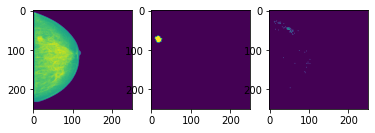

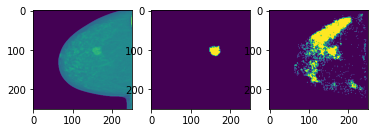

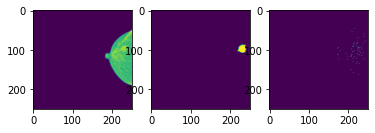

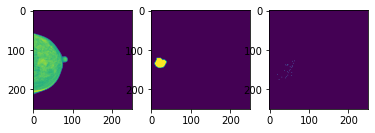

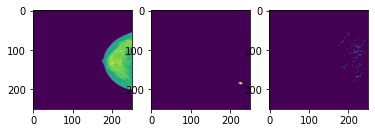

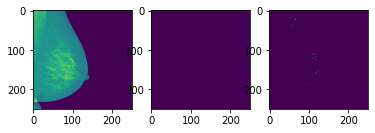

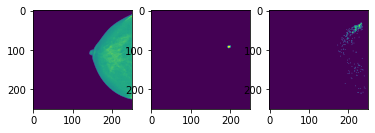

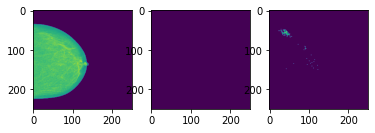

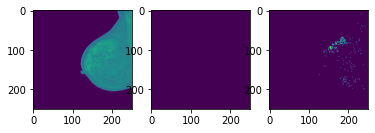

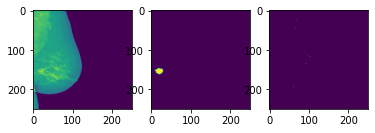

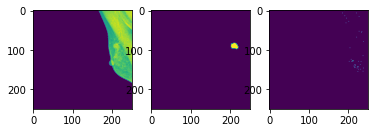

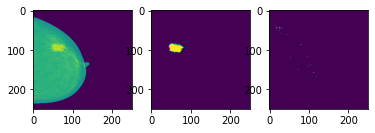

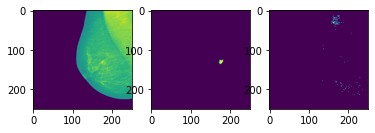

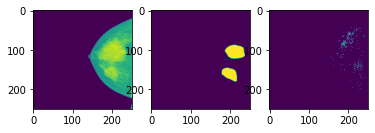

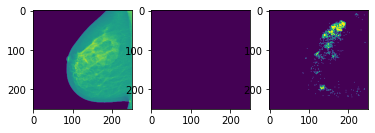

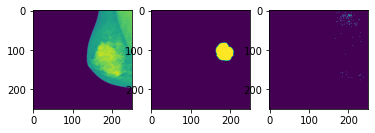

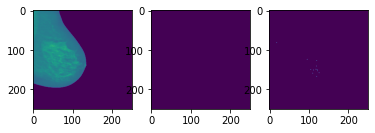

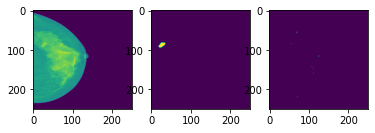

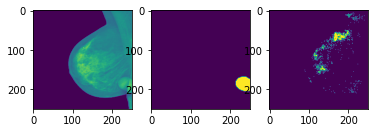

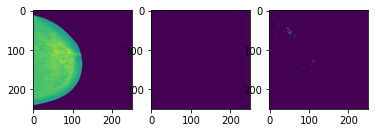

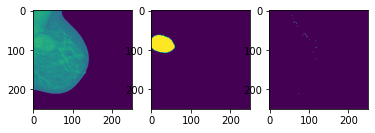

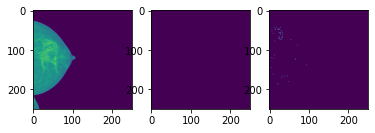

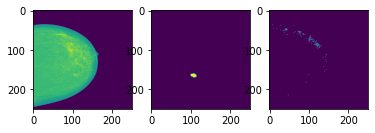

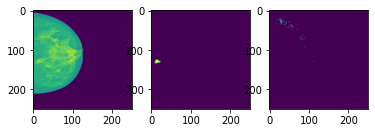

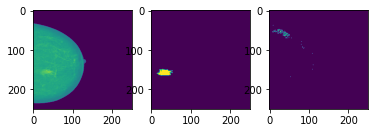

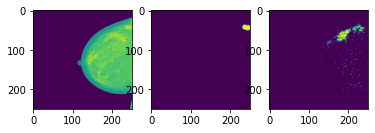

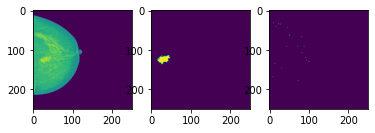

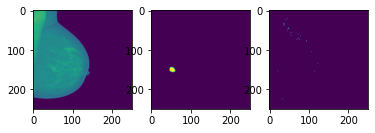

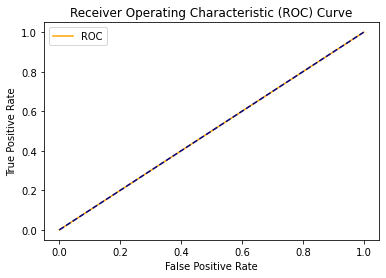

In [0]:
model.load_state_dict(torch.load('/gdrive/My Drive/'+path+name+'.pth'))

file = open('/gdrive/My Drive'+path+'testing.txt','w')
file.write('Testing with original UNet with 0.25 dropout trained on whole patches\n')

iou_tumour_list=[] #iou_tumour_list: for each of the 28 images, this list contains the corresponding iou value
ground=[] #ground: for each of the 28 image analzed, 1 correspond to images with a tumour
test_iou = 0.0
test_dice = 0.0
test_spec = 0.0
test_sens = 0.0
test_acc = 0.0
test_iou_tumour = 0.0
test_dice_tumour = 0.0
test_spec_tumour = 0.0
test_sens_tumour = 0.0
test_acc_tumour = 0.0

false_positive=0
true_positive=0
false_negative=0
true_negative=0
FPR=0
TPR=0
FNR=0
TNR=0
tum_count=0

################ test model
for i, data_t in enumerate(test_loader, 0):
  image_t, mask_t, image_re_t, mask_re_t = data_t
  outputs_t=model(image_re_t.unsqueeze(dim=0).float())
  outputs_final_probabilities_t, outputs_final_t = torch.max(outputs_t.squeeze(), axis=0)
  iou_tumour,iou_background,mean_iou = metrics(outputs_final_t,mask_re_t.squeeze(),'iou')
  test_iou += mean_iou 
  mean_iou,mean_dice,mean_spec,mean_sens,mean_acc= metrics(outputs_final_t,mask_re_t.squeeze(),'AllMean')
  test_dice += mean_dice
  test_spec += mean_spec
  test_sens += mean_sens
  test_acc += mean_acc
  iou_tumour_list.append(iou_tumour)
  print('\n\nTest Image %d : Mean iou %.3f' % (i+1, mean_iou))
  file.write('\n\nTest image %d : Mean iou %.3f, mean dice %.3f, mean spec %.3f, mean sens %.3f, mean acc %.3f' % (i+1,mean_iou,mean_dice,mean_spec,mean_sens,mean_acc))

  if 1 in mask_re_t:
    print('Tumour Iou: %.3f' % (iou_tumour))
    iou_tumour,dice_tumour,spec_tumour,sens_tumour,acc_tumour = metrics(outputs_final_t,mask_re_t.squeeze(),'AllTumour')
    test_iou_tumour += iou_tumour
    test_dice_tumour += dice_tumour
    test_spec_tumour += spec_tumour
    test_sens_tumour += sens_tumour
    test_acc_tumour += acc_tumour
    tum_count+=1
    file.write('\n tumour iou %.3f, tumour dice %.3f, tumour spec %.3f, tumour sens %.3f, tumour acc %.3f' % (iou_tumour,dice_tumour,spec_tumour,sens_tumour,acc_tumour))

  if 1 in mask_re_t:
    ground.append(1)
  else:
    ground.append(0)

  if 1 in mask_re_t.squeeze() and 1 in outputs_final_t.squeeze():
    true_positive=true_positive+1
  elif 1 not in mask_re_t.squeeze() and 1 in outputs_final_t.squeeze():
    false_positive=false_positive+1
  elif 1 in mask_re_t.squeeze() and 1 not in outputs_final_t.squeeze():
    false_negative=false_negative+1
  else:
    true_negative=true_negative+1

  fig = plt.figure()
  plt.subplot(1, 3, 1)
  plt.imshow(image_re_t.squeeze())
  plt.subplot(1, 3, 2)
  plt.imshow(mask_re_t.squeeze())
  plt.subplot(1, 3, 3)
  plt.imshow(outputs_final_t.detach().numpy())
  matplotlib.image.imsave('/gdrive/My Drive'+path+'test/'+name+'_image_'+str(i)+'.png',image_t.squeeze())
  matplotlib.image.imsave('/gdrive/My Drive'+path+'test/'+name+'_mask_'+str(i)+'.png',mask_t.squeeze())
  matplotlib.image.imsave('/gdrive/My Drive'+path+'test/'+name+'_prediction_'+str(i)+'.png',outputs_final_t.detach().numpy())


#print('\nOverall Test Images: test loss: %.3f' % (test_loss / len(test_loader)))
print('\n\n\nOver entire Test data set: average mean iou: %.3f' % (test_iou/ len(test_loader)))
file.write('\n\n\n\nOverall iou %.3f, overall dice %.3f, overall spec %.3f, overall sens %.3f, overall acc %.3f' % (test_iou/len(test_loader),test_dice/len(test_loader),test_spec/len(test_loader),test_sens/len(test_loader),test_acc/len(test_loader)))
print('\nAverage tumour iou (for mask that have tumour): %.3f' % (test_iou_tumour/tum_count), '\n')
file.write('\n\nOverall tumour iou %.3f, overall tumour dice %.3f, overall tumour spec %.3f, overall tumour sens %.3f, tumour overall acc %.3f' % (test_iou_tumour/tum_count,test_dice_tumour/tum_count,test_spec_tumour/tum_count,test_sens_tumour/tum_count,test_acc_tumour/tum_count))

####### from testing
FPR=false_positive/(false_positive+true_negative) #False Positive Rate 
TPR=true_positive/(true_positive+false_negative) #True Positive Rate ###Sens
FNR=false_negative/(false_negative+true_positive) #False Negative Rate
TNR=true_negative/(true_negative+false_positive) #True Negative Rate ###Spec

Acc=(true_negative+true_positive)/(false_positive+false_negative+true_negative+true_positive)

auc=ROC(iou_tumour_list,ground)

# f1, auprc = Recall_Precision(iou_tumour_list,ground)

# file.write('\n\n-------------------')
# file.write('\nAUC: ')
# file.write(auc)
# file.write('\nF1: ',f1,' ;AUPRC: ',auprc)
file.close()

# print('False Positive Rate:', FPR, '\n')
# print('True Positive Rate:', TPR, '\n')
# print('False Negative Rate:', FNR, '\n')
# print('True Negative Rate:', TNR, '\n')
# print('Acc:', acc, '\n')
# print('AUC:', auc, '\n')
# print('F1:', f1, 'AUPRC:', auprc, '\n')

